In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/waterQuality/wQuality.csv')

In [ ]:
train_data.head()

,Unnamed: 0,text,corr,class
0,0,predatory white pointers dingos saltwatercrocs...,1,0
1,1,this january simply note that are still having...,1,0
2,2,pronouns hehim height zodiac sign leo smoke he...,1,0
3,3,pronouns hehim height zodiac sign sagittarius ...,1,0
4,4,hoses are inchworm water lilies are powderblue...,1,0


In [ ]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['text'].apply(lambda x:len(str(x).split())) 

In [ ]:
print('Info about training data:')
print(train_data['corr'].value_counts())
print('Total comments: ', len(train_data))

max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
1    19824
0    18981
Name: corr, dtype: int64
Total comments:  38805


In [ ]:
num_words = 250000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[11, 23077, 23077, 710]]


In [ ]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['text'],\
                                                      train_data['corr'],\
                                                      test_size=0.3,\
                                                      random_state=0)

In [ ]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-11-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-11-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [ ]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [ ]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

[0, 1]

In [ ]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

2894     1
36529    0
22543    0
4659     1
13624    1
4738     1
7        1
4296     1
24283    0
28095    0
Name: corr, dtype: int64
Text to number
[1 0 0 1 1 1 1 1 0 0]
Number to category
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [ ]:
# looking for top 30k comments
max_features = 250000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005)))     

#model.add(tf.keras.layers.LSTM(64, dropout=0.1, return_sequences=True))
#model.add(tf.keras.layers.Dense(3))

#model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                            kernel_regularizer=regularizers.l2(0.005),\
                                                            bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(2,activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=["CategoricalAccuracy", AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           16000000  
                                                                 
 lstm (LSTM)                 (None, 256, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

In [ ]:
x_test.shape

(11642, 256)

In [ ]:
test_labels.shape

(11642, 2)

In [ ]:
# Training model
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(x_train,
                    train_labels,
                    epochs= epochs,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
849/849 [==============================] - 889s 1s/step - loss: 0.8104 - categorical_accuracy: 0.8338 - auc: 0.9263 - val_loss: 0.4431 - val_categorical_accuracy: 0.9454 - val_auc: 0.9892
Epoch 2/10
849/849 [==============================] - 851s 1s/step - loss: 0.3667 - categorical_accuracy: 0.9442 - auc: 0.9838 - val_loss: 0.2956 - val_categorical_accuracy: 0.9437 - val_auc: 0.9895
Epoch 3/10
849/849 [==============================] - 847s 998ms/step - loss: 0.2948 - categorical_accuracy: 0.9465 - auc: 0.9873 - val_loss: 0.2474 - val_categorical_accuracy: 0.9481 - val_auc: 0.9906
Epoch 4/10
849/849 [==============================] - 839s 988ms/step - loss: 0.2619 - categorical_accuracy: 0.9490 - auc: 0.9886 - val_loss: 0.2739 - val_categorical_accuracy: 0.9426 - val_auc: 0.9895
Epoch 5/10
849/849 [==============================] - 837s 986ms/step - loss: 0.2475 - categorical_accuracy: 0.9510 - auc: 0.9896 - val_loss: 0.2596 - val_categorical_accuracy: 0.9411 - val_auc: 0.9

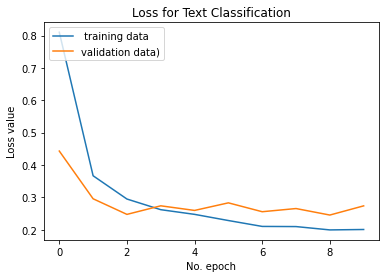

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

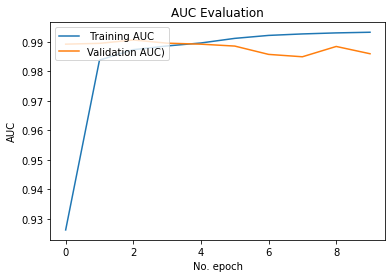

In [ ]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
X_test

20818    why would the governor florida kansas city foo...
7919     globalwarming the global water monitor consort...
10999    noses are vivid violet water lilies are blue s...
27239             nasdaq about days bears better wake soon
30173                                    football specific
                               ...                        
22062                   fifa realistic career mode everton
6368     flash gordon from got for this wonderful examp...
4379     atheists quote reply this tweet with your best...
34052                          chelsea has ruined football
11004    free tarot deck reviews the suits the good tar...
Name: text, Length: 11642, dtype: object

In [ ]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-22-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
364/364 [==============================] - 24s 65ms/step


array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
y_test.shape
y_test

NameError: ignored

In [ ]:
labels = [0, 1]
#labels = labels.values.astype(int).astype(str)
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5733
           1       0.95      0.94      0.95      5909

    accuracy                           0.95     11642
   macro avg       0.95      0.95      0.95     11642
weighted avg       0.95      0.95      0.95     11642

